# Comparative Model Analysis: Transformer vs PCA-Logistic

This notebook compares what different models learn about protein importance for cancer classification:
- **Graph Transformer**: SHAP importance values
- **PCA-Logistic**: Component-weighted protein importance
- **PPI Network**: STRING protein-protein interaction structure
- **Attention Patterns**: What the transformer attends to

Goal: Identify unique patterns each model discovers.


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from scipy.stats import pearsonr, spearmanr
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix

plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

plots_dir = Path('plots')
output_dir = plots_dir / 'Model_Comparison_Plots'
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Output directory: {output_dir}")


Output directory: plots/Model_Comparison_Plots


## 1. Load Pre-computed Results


In [66]:
# Load SHAP results
with open(plots_dir / 'SHAP_Plots' / 'top_proteins.json', 'r') as f:
    shap_data = json.load(f)

shap_proteins = [p['protein'] for p in shap_data]
shap_importance = np.array([p['importance'] for p in shap_data])
shap_dict = {p['protein']: p['importance'] for p in shap_data}

print(f"Loaded SHAP: {len(shap_data)} proteins")
print(f"Top 5: {shap_proteins[:5]}")

# Load PCA-Logistic results
with open(plots_dir / 'PCA_Cox_Plots' / 'top_proteins.json', 'r') as f:
    pca_data = json.load(f)

pca_proteins = [p['protein'] for p in pca_data]
pca_importance = np.array([p['importance'] for p in pca_data])
pca_dict = {p['protein']: p['importance'] for p in pca_data}

print(f"\nLoaded PCA-Logistic: {len(pca_data)} proteins")
print(f"Top 5: {pca_proteins[:5]}")

# Load PPI network (at repository root, 4 levels up from this notebook)
prior_path = Path('../../../../priors/tcga_string_prior.npz')
prior_data = np.load(prior_path, allow_pickle=True)
A = prior_data['A']
all_proteins = prior_data['protein_cols'].tolist()

print(f"\nLoaded PPI network: {A.shape[0]} proteins, {int(A.sum()//2)} edges")


Loaded SHAP: 50 proteins
Top 5: ['ADAR|ADAR1', 'ESR1|ER-alpha', 'ARID1A|ARID1A', 'COPS5|JAB1', 'FASN|FASN']

Loaded PCA-Logistic: 50 proteins
Top 5: ['COPS5|JAB1', 'ERBB3|HER3', 'SRC|Src', 'ARID1A|ARID1A', 'CASP3|Caspase-3']

Loaded PPI network: 198 proteins, 1053 edges


### Load Model and Extract Attention Scores


In [67]:
import torch
import sys

# Add classifier to path
classifier_dir = Path('../../../classifiers/graph_transformer').resolve()
if str(classifier_dir) not in sys.path:
    sys.path.insert(0, str(classifier_dir))

from model import GraphTransformerClassifier
from graph_prior import load_graph_prior, get_graph_features_as_tensors

# Load graph prior with diffusion kernel and PE
prior_path_str = str(Path('../../../../priors/tcga_string_prior.npz').resolve())
graph_prior_full = load_graph_prior(prior_path_str)
graph_tensors = get_graph_features_as_tensors(graph_prior_full, device='cpu')

# Load checkpoint
checkpoint_path = Path('../../../Results/classifiers/cancer_type_classifiers/transformer/checkpoints/best_model.pt')
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# Build model
model = GraphTransformerClassifier(
    n_proteins=A.shape[0],
    n_classes=checkpoint['label_info']['n_classes'],
    diffusion_kernel=graph_tensors['K'],
    positional_encodings=graph_tensors['PE'],
    embedding_dim=checkpoint['config']['MODEL']['embedding_dim'],
    n_layers=checkpoint['config']['MODEL']['n_layers'],
    n_heads=checkpoint['config']['MODEL']['n_heads'],
    dropout=checkpoint['config']['MODEL']['dropout']
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Model loaded: {len(model.transformer)} layers, {model.n_heads} heads")


Loaded prior: 198 proteins, 1184 edges
Model loaded: 4 layers, 8 heads


In [68]:
# Extract attention patterns
from collections import defaultdict

class AttentionExtractor:
    def __init__(self, model):
        self.model = model
        self.attention_maps = defaultdict(list)
        self.hooks = []
    
    def register_hooks(self):
        for layer_idx, layer in enumerate(self.model.transformer):
            hook = layer.self_attn.register_forward_hook(self._make_hook(layer_idx))
            self.hooks.append(hook)
    
    def _make_hook(self, layer_idx):
        def hook_fn(module, input_tuple, output):
            x = input_tuple[0]
            attn_bias = input_tuple[1] if len(input_tuple) > 1 else None
            
            B, L, D = x.shape
            Q = module.q_proj(x).view(B, L, module.n_heads, module.d_head).transpose(1, 2)
            K = module.k_proj(x).view(B, L, module.n_heads, module.d_head).transpose(1, 2)
            
            scores = torch.matmul(Q, K.transpose(-2, -1)) / (module.d_head ** 0.5)
            if attn_bias is not None:
                scores = scores + attn_bias
            
            attn_weights = torch.softmax(scores, dim=-1)
            self.attention_maps[layer_idx].append(attn_weights.detach().cpu())
        return hook_fn
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# Create dummy data for attention extraction
dummy_data = torch.randn(10, A.shape[0])

extractor = AttentionExtractor(model)
extractor.register_hooks()

with torch.no_grad():
    _ = model(dummy_data)

# Process attention: average across samples, heads, and layers
all_attns = []
for layer_idx in sorted(extractor.attention_maps.keys()):
    layer_attns = torch.cat(extractor.attention_maps[layer_idx], dim=0)
    layer_attns = layer_attns[:, :, 1:, 1:]  # Remove CLS token
    layer_attns = layer_attns.mean(dim=(0, 1))  # Average samples and heads
    all_attns.append(layer_attns)

attention_matrix = torch.stack(all_attns).mean(dim=0).numpy()

extractor.remove_hooks()

print(f"Extracted attention matrix: {attention_matrix.shape}")
print(f"Mean attention: {attention_matrix.mean():.6f}")
print(f"Std attention: {attention_matrix.std():.6f}")


Extracted attention matrix: (198, 198)
Mean attention: 0.005026
Std attention: 0.000653


In [69]:
# Compute per-protein attention scores
attention_received = attention_matrix.sum(axis=0)
attention_given = attention_matrix.sum(axis=1)
attention_score = (attention_received + attention_given) / 2

# Create protein->attention mapping
protein_attention = {all_proteins[i]: attention_score[i] for i in range(len(all_proteins))}

print("Top 10 proteins by attention:")
top_attn_idx = np.argsort(attention_score)[-10:][::-1]
for idx in top_attn_idx:
    print(f"  {all_proteins[idx]:30s}: {attention_score[idx]:.6f}")


Top 10 proteins by attention:
  FASN|FASN                     : 1.218639
  ESR1|ER-alpha                 : 1.204794
  TGM2|Transglutaminase         : 1.151072
  VHL|VHL                       : 1.128380
  EGFR|EGFR_pY1068              : 1.126743
  MYH11|MYH11                   : 1.121399
  ITGA2|CD49b                   : 1.113953
  CLDN7|Claudin-7               : 1.112823
  RICTOR|Rictor_pT1135          : 1.093603
  PRKCA |PKC-alpha_pS657        : 1.087665


## 2. Top 20 Comparison with Attention Scores


In [70]:
shap_top20 = set(shap_proteins[:20])
pca_top20 = set(pca_proteins[:20])
overlap = shap_top20 & pca_top20

# Create comprehensive comparison table
top20_comparison = []
for i in range(20):
    shap_protein = shap_proteins[i] if i < len(shap_proteins) else 'N/A'
    pca_protein = pca_proteins[i] if i < len(pca_proteins) else 'N/A'
    
    shap_attn = protein_attention.get(shap_protein, 0) if shap_protein != 'N/A' else 0
    pca_attn = protein_attention.get(pca_protein, 0) if pca_protein != 'N/A' else 0
    
    in_overlap = 'BOTH' if shap_protein in overlap or pca_protein in overlap else ''
    
    top20_comparison.append({
        'Rank': i + 1,
        'Transformer_Protein': shap_protein,
        'SHAP': f"{shap_importance[i]:.4f}" if i < len(shap_importance) else 'N/A',
        'Attn_Trans': f"{shap_attn:.6f}",
        'PCA_Protein': pca_protein,
        'PCA_Score': f"{pca_importance[i]:.4f}" if i < len(pca_importance) else 'N/A',
        'Attn_PCA': f"{pca_attn:.6f}",
        'Overlap': in_overlap
    })

top20_df = pd.DataFrame(top20_comparison)
print("Top 20 Proteins: SHAP + Attention + PCA Comparison")
print("="*90)
top20_df


Top 20 Proteins: SHAP + Attention + PCA Comparison


,Rank,Transformer_Protein,SHAP,Attn_Trans,PCA_Protein,PCA_Score,Attn_PCA,Overlap
0,1,ADAR|ADAR1,0.5132,0.975056,COPS5|JAB1,1.4979,1.008671,BOTH
1,2,ESR1|ER-alpha,0.2983,1.204794,ERBB3|HER3,1.4412,1.020642,
2,3,ARID1A|ARID1A,0.2101,1.007223,SRC|Src,1.3697,0.971784,BOTH
3,4,COPS5|JAB1,0.2100,1.008671,ARID1A|ARID1A,1.3335,1.007223,BOTH
4,5,FASN|FASN,0.2080,1.218639,CASP3|Caspase-3,1.3278,0.980872,BOTH
5,6,CASP3|Caspase-3,0.1796,0.980872,RAD50|Rad50,1.3177,0.984362,BOTH
6,7,TIGAR|TIGAR,0.1767,1.013247,NKX2-1|TTF1,1.3127,0.953120,
7,8,VHL|VHL,0.1596,1.128380,CTNNA1|alpha-Catenin,1.3076,1.025235,
8,9,MYH11|MYH11,0.1449,1.121399,CASP9|Caspase-9,1.3071,0.967849,
9,10,GATA3|GATA3,0.1338,0.968002,PRKAA1|AMPK_pT172,1.2798,0.955088,


In [71]:
# Analyze correlation between SHAP and Attention
shap_attn_vals = [protein_attention.get(p, 0) for p in shap_proteins[:20]]
pca_attn_vals = [protein_attention.get(p, 0) for p in pca_proteins[:20]]

print("Attention Score Analysis:")
print(f"  Transformer top 20 - Mean attention: {np.mean(shap_attn_vals):.6f}")
print(f"  PCA-Logistic top 20 - Mean attention: {np.mean(pca_attn_vals):.6f}")

# Correlation between SHAP and attention for transformer proteins
common_trans = [p for p in shap_proteins[:50] if p in all_proteins]
trans_shap = [shap_dict[p] for p in common_trans]
trans_attn = [protein_attention[p] for p in common_trans]

if len(trans_shap) > 2:
    corr_shap_attn = np.corrcoef(trans_shap, trans_attn)[0, 1]
    print(f"\n  Correlation (SHAP vs Attention): {corr_shap_attn:.3f}")
    print("  → High correlation = attention drives importance")
    print("  → Low correlation = other factors (embeddings, FFN) drive importance")


Attention Score Analysis:
  Transformer top 20 - Mean attention: 1.052160
  PCA-Logistic top 20 - Mean attention: 0.993698

  Correlation (SHAP vs Attention): 0.188
  → High correlation = attention drives importance
  → Low correlation = other factors (embeddings, FFN) drive importance


## 3. Overlap Analysis


In [72]:
shap_unique = shap_top20 - pca_top20
pca_unique = pca_top20 - shap_top20

print("Top 20 Protein Overlap:")
print(f"  Both models: {len(overlap)} proteins ({100*len(overlap)/20:.0f}%)")
print(f"  Transformer only: {len(shap_unique)} proteins")
print(f"  PCA-Logistic only: {len(pca_unique)} proteins")
print(f"\nOverlap proteins:\n  {sorted(overlap)}")
print(f"\nTransformer unique:\n  {sorted(shap_unique)}")
print(f"\nPCA-Logistic unique:\n  {sorted(pca_unique)}")


Top 20 Protein Overlap:
  Both models: 3 proteins (15%)
  Transformer only: 17 proteins
  PCA-Logistic only: 17 proteins

Overlap proteins:
  ['ARID1A|ARID1A', 'CASP3|Caspase-3', 'COPS5|JAB1']

Transformer unique:
  ['ACVRL1|ACVRL1', 'ADAR|ADAR1', 'AR|AR', 'CLDN7|Claudin-7', 'ESR1|ER-alpha', 'ESR1|ER-alpha_pS118', 'FASN|FASN', 'GAB2|GAB2', 'GATA3|GATA3', 'MYH11|MYH11', 'PARP1|PARP1', 'PEA15|PEA15_pS116', 'PRKCD|PKC-delta_pS664', 'SMAD1|Smad1', 'TFRC|TFRC', 'TIGAR|TIGAR', 'VHL|VHL']

PCA-Logistic unique:
  ['BCL2L1|Bcl-xL', 'CASP9|Caspase-9', 'CDH3|P-Cadherin', 'CDK1|CDK1', 'CTNNA1|alpha-Catenin', 'EIF4EBP1|4E-BP1_pS65', 'ERBB2|HER2', 'ERBB2|HER2_pY1248', 'ERBB3|HER3', 'KIT|c-Kit', 'NKX2-1|TTF1', 'PRKAA1|AMPK_pT172', 'RAD50|Rad50', 'SQSTM1|p62-LCK-ligand', 'SRC|Src', 'XBP1|XBP1', 'YBX1|YB-1']


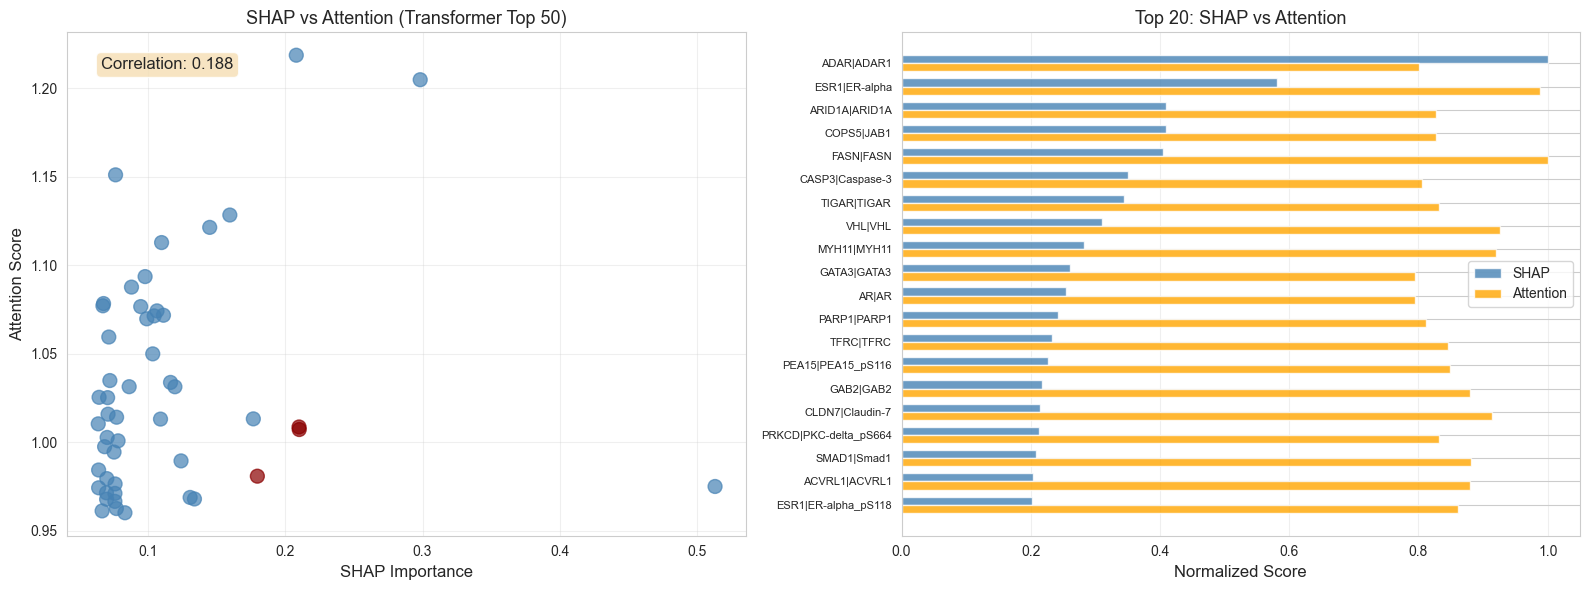

In [73]:
# Visualize SHAP vs Attention for Transformer proteins
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Scatter plot
ax = axes[0]
common_trans = [p for p in shap_proteins[:50] if p in all_proteins]
trans_shap_vals = [shap_dict[p] for p in common_trans]
trans_attn_vals = [protein_attention[p] for p in common_trans]

colors = ['darkred' if p in overlap else 'steelblue' for p in common_trans]
ax.scatter(trans_shap_vals, trans_attn_vals, c=colors, alpha=0.7, s=100)

if len(trans_shap_vals) > 2:
    corr = np.corrcoef(trans_shap_vals, trans_attn_vals)[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
           transform=ax.transAxes, fontsize=12,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_xlabel('SHAP Importance', fontsize=12)
ax.set_ylabel('Attention Score', fontsize=12)
ax.set_title('SHAP vs Attention (Transformer Top 50)', fontsize=13)
ax.grid(alpha=0.3)

# Right: Bar comparison for top 20
ax = axes[1]
y_pos = np.arange(20)
width = 0.35

# Normalize for visualization
shap_norm = shap_importance[:20] / shap_importance[:20].max()
attn_norm = np.array(shap_attn_vals[:20]) / max(shap_attn_vals[:20])

ax.barh(y_pos - width/2, shap_norm, width, label='SHAP', color='steelblue', alpha=0.8)
ax.barh(y_pos + width/2, attn_norm, width, label='Attention', color='orange', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(shap_proteins[:20], fontsize=8)
ax.set_xlabel('Normalized Score', fontsize=12)
ax.set_title('Top 20: SHAP vs Attention', fontsize=13)
ax.invert_yaxis()
ax.legend()
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(output_dir / 'shap_vs_attention.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Focused Heatmaps: Top 20 SHAP Proteins

Visualize attention and PPI structure for just the top 20 most important proteins.


In [74]:
# Get indices for top 20 SHAP proteins
top20_shap_names = shap_proteins[:20]
top20_indices = [all_proteins.index(p) for p in top20_shap_names if p in all_proteins]

print(f"Top 20 SHAP proteins: {len(top20_indices)} found in PPI network")
print(f"Proteins: {top20_shap_names}")


Top 20 SHAP proteins: 20 found in PPI network
Proteins: ['ADAR|ADAR1', 'ESR1|ER-alpha', 'ARID1A|ARID1A', 'COPS5|JAB1', 'FASN|FASN', 'CASP3|Caspase-3', 'TIGAR|TIGAR', 'VHL|VHL', 'MYH11|MYH11', 'GATA3|GATA3', 'AR|AR', 'PARP1|PARP1', 'TFRC|TFRC', 'PEA15|PEA15_pS116', 'GAB2|GAB2', 'CLDN7|Claudin-7', 'PRKCD|PKC-delta_pS664', 'SMAD1|Smad1', 'ACVRL1|ACVRL1', 'ESR1|ER-alpha_pS118']


In [75]:
# Extract submatrices for top 20 proteins
attention_top20 = attention_matrix[np.ix_(top20_indices, top20_indices)]
ppi_top20 = A[np.ix_(top20_indices, top20_indices)]
top20_labels = [top20_shap_names[i] for i in range(len(top20_indices))]

print(f"Attention matrix (top 20): {attention_top20.shape}")
print(f"PPI matrix (top 20): {ppi_top20.shape}")
print(f"PPI edges in top 20: {int(ppi_top20.sum() / 2)}")


Attention matrix (top 20): (20, 20)
PPI matrix (top 20): (20, 20)
PPI edges in top 20: 6


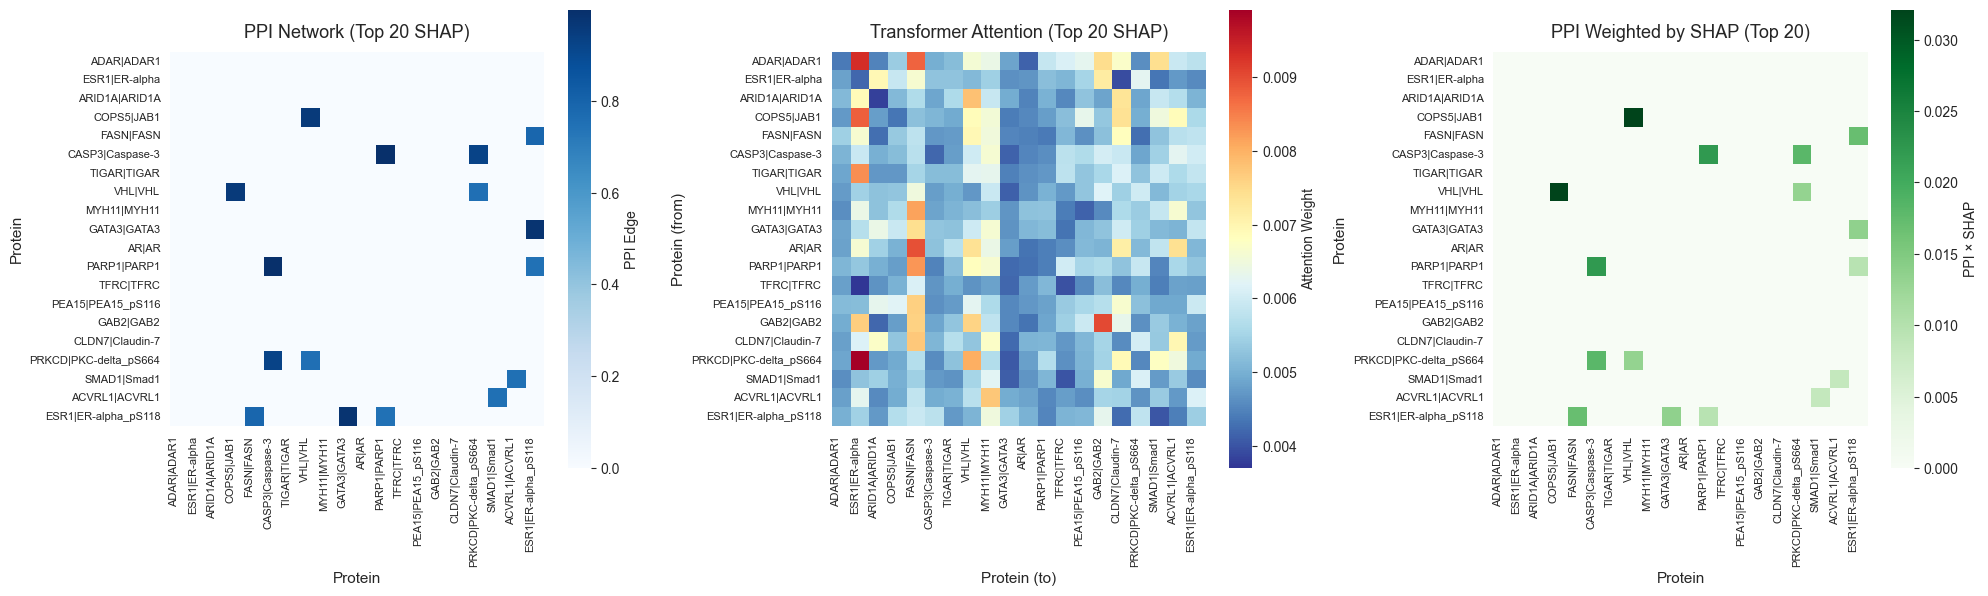

In [76]:
# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Left: PPI Adjacency
ax = axes[0]
sns.heatmap(ppi_top20, cmap='Blues', square=True, 
           xticklabels=top20_labels, yticklabels=top20_labels,
           cbar_kws={'label': 'PPI Edge'},
           ax=ax)
ax.set_title('PPI Network (Top 20 SHAP)', fontsize=13, pad=10)
ax.set_xlabel('Protein', fontsize=11)
ax.set_ylabel('Protein', fontsize=11)
plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=8)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

# Middle: Attention
ax = axes[1]
sns.heatmap(attention_top20, cmap='RdYlBu_r', square=True,
           xticklabels=top20_labels, yticklabels=top20_labels,
           cbar_kws={'label': 'Attention Weight'},
           ax=ax)
ax.set_title('Transformer Attention (Top 20 SHAP)', fontsize=13, pad=10)
ax.set_xlabel('Protein (to)', fontsize=11)
ax.set_ylabel('Protein (from)', fontsize=11)
plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=8)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

# Right: SHAP importance overlay on PPI
ax = axes[2]
# Create weighted adjacency: PPI edges weighted by SHAP importance
shap_weights = shap_importance[:len(top20_indices)]
shap_outer = np.outer(shap_weights, shap_weights)
ppi_weighted = ppi_top20 * shap_outer

sns.heatmap(ppi_weighted, cmap='Greens', square=True,
           xticklabels=top20_labels, yticklabels=top20_labels,
           cbar_kws={'label': 'PPI × SHAP'},
           ax=ax)
ax.set_title('PPI Weighted by SHAP (Top 20)', fontsize=13, pad=10)
ax.set_xlabel('Protein', fontsize=11)
ax.set_ylabel('Protein', fontsize=11)
plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=8)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(output_dir / 'top20_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()


In [77]:
# Analyze attention vs PPI structure for top 20
ppi_edges = ppi_top20[np.triu_indices_from(ppi_top20, k=1)]
attn_edges = attention_top20[np.triu_indices_from(attention_top20, k=1)]

edge_mask = ppi_edges > 0
non_edge_mask = ppi_edges == 0

if edge_mask.sum() > 0:
    print("Attention Patterns in Top 20 Proteins:")
    print(f"  PPI edges: {edge_mask.sum()} pairs")
    print(f"  Mean attention to PPI neighbors: {attn_edges[edge_mask].mean():.6f}")
    print(f"  Mean attention to non-neighbors: {attn_edges[non_edge_mask].mean():.6f}")
    ratio = attn_edges[edge_mask].mean() / attn_edges[non_edge_mask].mean()
    print(f"  Ratio (edge/non-edge): {ratio:.2f}x")
    
    if ratio > 1.1:
        print("\n  → Transformer DOES preferentially attend to PPI neighbors")
    elif ratio < 0.9:
        print("\n  → Transformer AVOIDS attending to PPI neighbors")
    else:
        print("\n  → Transformer attention is UNIFORM (not PPI-guided)")


Attention Patterns in Top 20 Proteins:
  PPI edges: 8 pairs
  Mean attention to PPI neighbors: 0.005585
  Mean attention to non-neighbors: 0.005472
  Ratio (edge/non-edge): 1.02x

  → Transformer attention is UNIFORM (not PPI-guided)


### Interpretation: Attention vs Structure

The three heatmaps show:
1. **PPI Network** - Ground truth protein interactions from STRING database
2. **Transformer Attention** - What the model attends to (learned)
3. **PPI × SHAP** - Important protein interactions (combining structure + importance)

If attention mirrors PPI structure → model uses graph information in attention mechanism  
If attention is uniform → model uses graph through diffusion kernel bias instead


### Individual Heatmaps for Better Detail


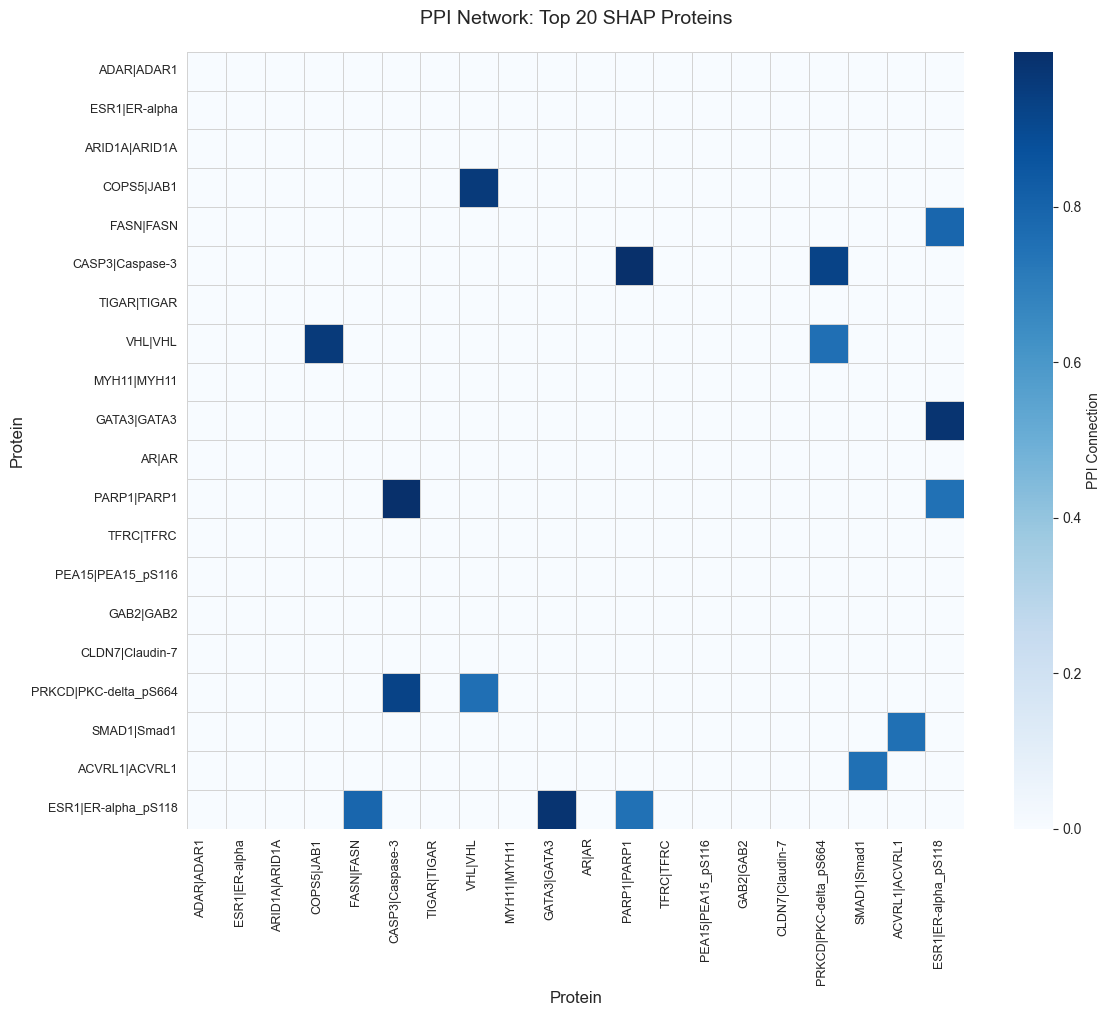

PPI edges: 6/190 possible


In [78]:
# PPI Network heatmap (large)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(ppi_top20, cmap='Blues', square=True, 
           xticklabels=top20_labels, yticklabels=top20_labels,
           cbar_kws={'label': 'PPI Connection'},
           linewidths=0.5, linecolor='lightgray',
           ax=ax)
ax.set_title('PPI Network: Top 20 SHAP Proteins', fontsize=14, pad=20)
ax.set_xlabel('Protein', fontsize=12)
ax.set_ylabel('Protein', fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=9)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(output_dir / 'ppi_top20_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PPI edges: {int(ppi_top20.sum()/2)}/{len(top20_indices)*(len(top20_indices)-1)//2} possible")


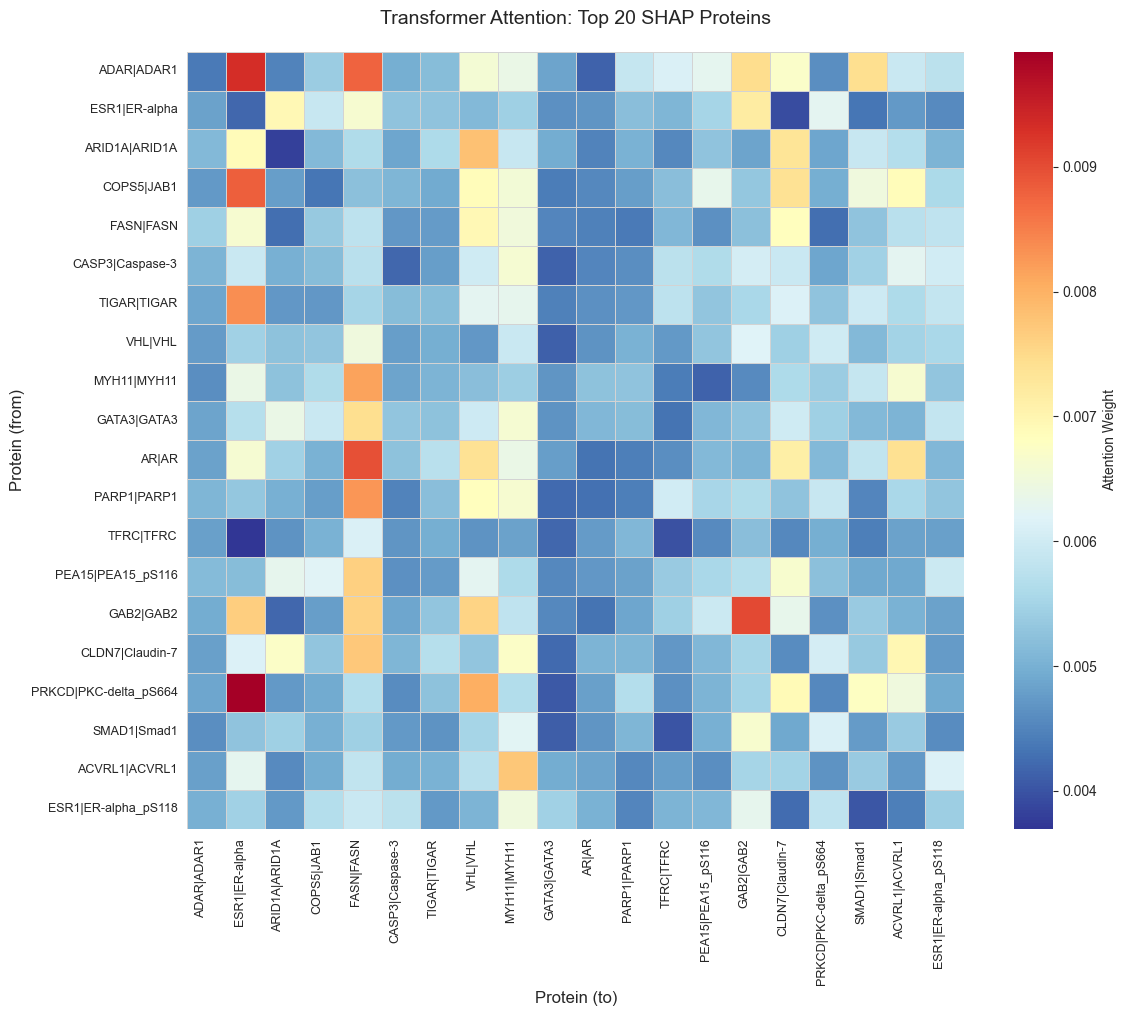

Attention range: [0.003697, 0.009920]


In [79]:
# Attention heatmap (large)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(attention_top20, cmap='RdYlBu_r', square=True,
           xticklabels=top20_labels, yticklabels=top20_labels,
           cbar_kws={'label': 'Attention Weight'},
           linewidths=0.5, linecolor='lightgray',
           ax=ax)
ax.set_title('Transformer Attention: Top 20 SHAP Proteins', fontsize=14, pad=20)
ax.set_xlabel('Protein (to)', fontsize=12)
ax.set_ylabel('Protein (from)', fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=9)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(output_dir / 'attention_top20_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Attention range: [{attention_top20.min():.6f}, {attention_top20.max():.6f}]")


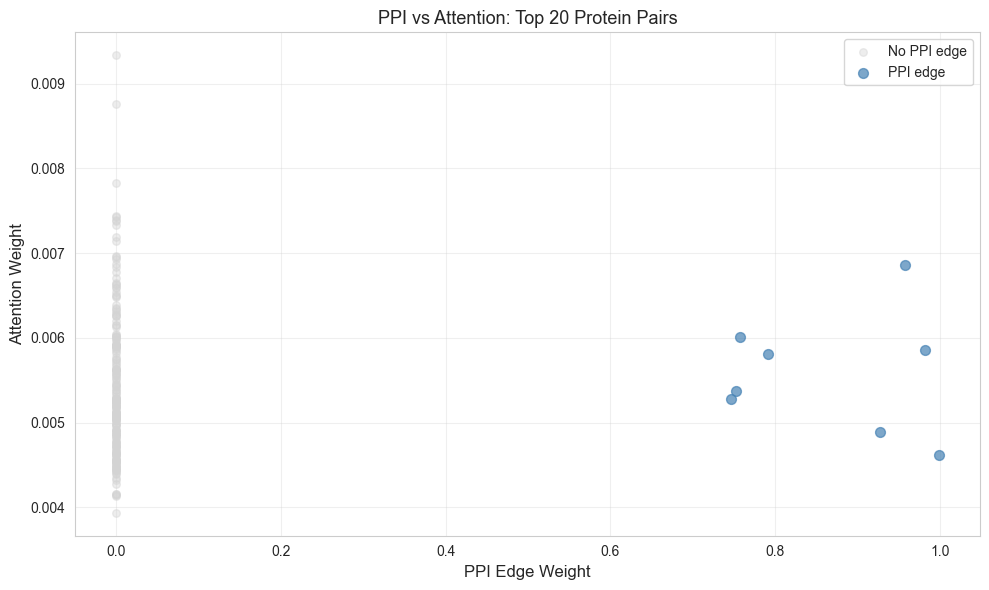

PPI-connected pairs: 8/190 (4.2%)


In [80]:
# Create correlation plot: PPI vs Attention (protein pairs)
ppi_flat = ppi_top20[np.triu_indices_from(ppi_top20, k=1)]
attn_flat = attention_top20[np.triu_indices_from(attention_top20, k=1)]

fig, ax = plt.subplots(figsize=(10, 6))

# Separate by PPI connection
connected = ppi_flat > 0
ax.scatter(ppi_flat[~connected], attn_flat[~connected], 
          alpha=0.4, s=30, c='lightgray', label='No PPI edge')
ax.scatter(ppi_flat[connected], attn_flat[connected],
          alpha=0.7, s=50, c='steelblue', label='PPI edge')

ax.set_xlabel('PPI Edge Weight', fontsize=12)
ax.set_ylabel('Attention Weight', fontsize=12)
ax.set_title('PPI vs Attention: Top 20 Protein Pairs', fontsize=13)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'ppi_vs_attention_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PPI-connected pairs: {connected.sum()}/{len(ppi_flat)} ({100*connected.sum()/len(ppi_flat):.1f}%)")


## 2. Top 20 Overlap Analysis


In [81]:
shap_top20 = set(shap_proteins[:20])
pca_top20 = set(pca_proteins[:20])

overlap = shap_top20 & pca_top20
shap_unique = shap_top20 - pca_top20
pca_unique = pca_top20 - shap_top20

print("Top 20 Protein Overlap:")
print(f"  Both models: {len(overlap)} proteins ({100*len(overlap)/20:.0f}%)")
print(f"  Transformer only: {len(shap_unique)} proteins")
print(f"  PCA-Logistic only: {len(pca_unique)} proteins")
print(f"\nOverlap proteins:\n  {sorted(overlap)}")
print(f"\nTransformer unique:\n  {sorted(shap_unique)}")
print(f"\nPCA-Logistic unique:\n  {sorted(pca_unique)}")


Top 20 Protein Overlap:
  Both models: 3 proteins (15%)
  Transformer only: 17 proteins
  PCA-Logistic only: 17 proteins

Overlap proteins:
  ['ARID1A|ARID1A', 'CASP3|Caspase-3', 'COPS5|JAB1']

Transformer unique:
  ['ACVRL1|ACVRL1', 'ADAR|ADAR1', 'AR|AR', 'CLDN7|Claudin-7', 'ESR1|ER-alpha', 'ESR1|ER-alpha_pS118', 'FASN|FASN', 'GAB2|GAB2', 'GATA3|GATA3', 'MYH11|MYH11', 'PARP1|PARP1', 'PEA15|PEA15_pS116', 'PRKCD|PKC-delta_pS664', 'SMAD1|Smad1', 'TFRC|TFRC', 'TIGAR|TIGAR', 'VHL|VHL']

PCA-Logistic unique:
  ['BCL2L1|Bcl-xL', 'CASP9|Caspase-9', 'CDH3|P-Cadherin', 'CDK1|CDK1', 'CTNNA1|alpha-Catenin', 'EIF4EBP1|4E-BP1_pS65', 'ERBB2|HER2', 'ERBB2|HER2_pY1248', 'ERBB3|HER3', 'KIT|c-Kit', 'NKX2-1|TTF1', 'PRKAA1|AMPK_pT172', 'RAD50|Rad50', 'SQSTM1|p62-LCK-ligand', 'SRC|Src', 'XBP1|XBP1', 'YBX1|YB-1']


In [82]:
# Create detailed comparison table for top 20
top20_comparison = []
for i in range(20):
    shap_protein = shap_proteins[i] if i < len(shap_proteins) else 'N/A'
    pca_protein = pca_proteins[i] if i < len(pca_proteins) else 'N/A'
    
    in_overlap = 'BOTH' if shap_protein in overlap or pca_protein in overlap else ''
    
    top20_comparison.append({
        'Rank': i + 1,
        'Transformer': shap_protein,
        'SHAP_Score': f"{shap_importance[i]:.4f}" if i < len(shap_importance) else 'N/A',
        'PCA-Logistic': pca_protein,
        'PCA_Score': f"{pca_importance[i]:.4f}" if i < len(pca_importance) else 'N/A',
        'Overlap': in_overlap
    })

top20_df = pd.DataFrame(top20_comparison)
print("Top 20 Proteins: Side-by-Side Comparison")
print("="*80)
top20_df


Top 20 Proteins: Side-by-Side Comparison


,Rank,Transformer,SHAP_Score,PCA-Logistic,PCA_Score,Overlap
0,1,ADAR|ADAR1,0.5132,COPS5|JAB1,1.4979,BOTH
1,2,ESR1|ER-alpha,0.2983,ERBB3|HER3,1.4412,
2,3,ARID1A|ARID1A,0.2101,SRC|Src,1.3697,BOTH
3,4,COPS5|JAB1,0.2100,ARID1A|ARID1A,1.3335,BOTH
4,5,FASN|FASN,0.2080,CASP3|Caspase-3,1.3278,BOTH
5,6,CASP3|Caspase-3,0.1796,RAD50|Rad50,1.3177,BOTH
6,7,TIGAR|TIGAR,0.1767,NKX2-1|TTF1,1.3127,
7,8,VHL|VHL,0.1596,CTNNA1|alpha-Catenin,1.3076,
8,9,MYH11|MYH11,0.1449,CASP9|Caspase-9,1.3071,
9,10,GATA3|GATA3,0.1338,PRKAA1|AMPK_pT172,1.2798,


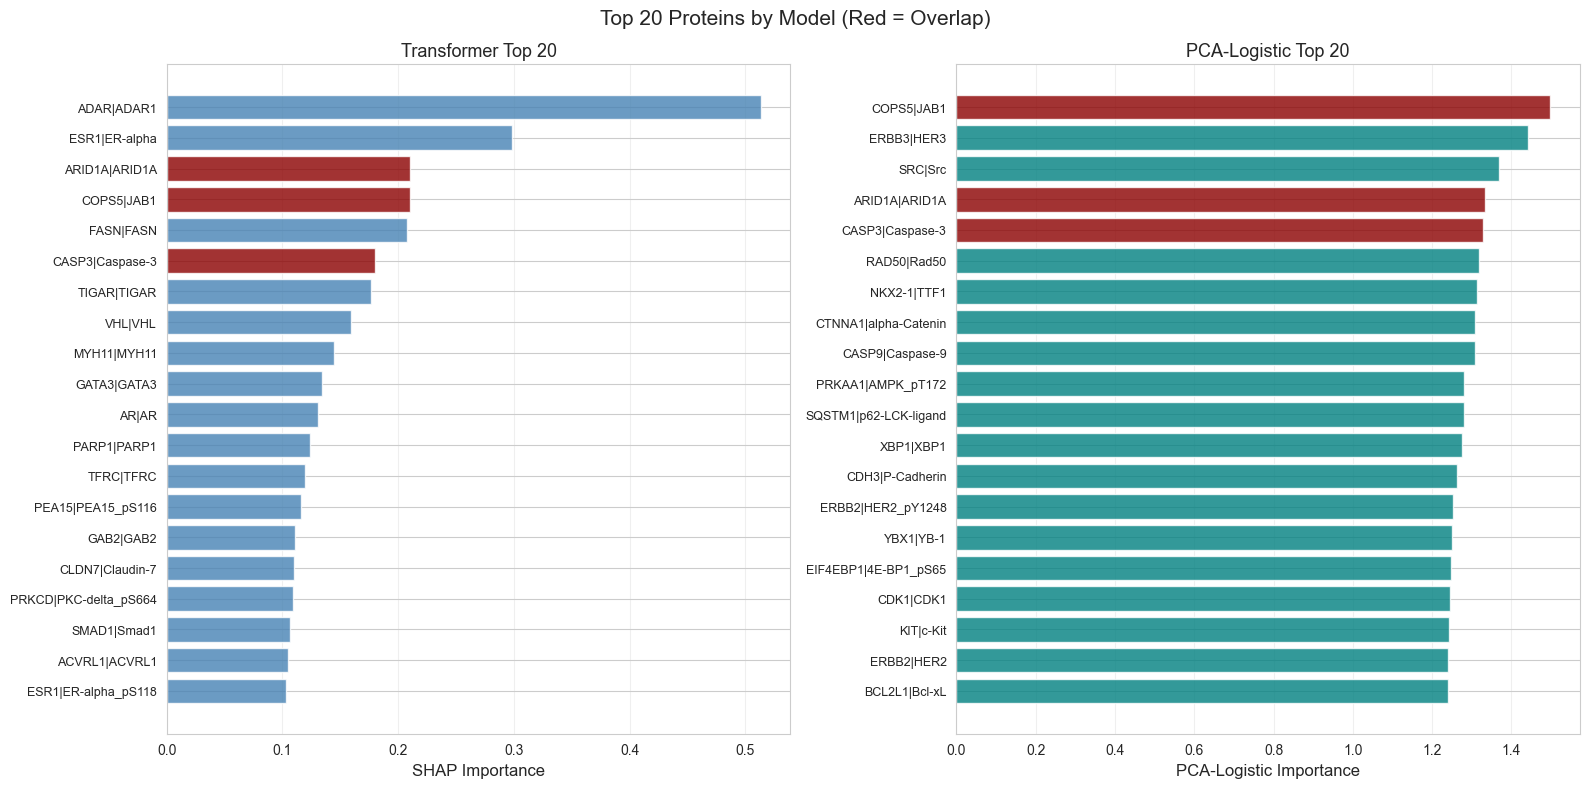

In [83]:
# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

y_pos = np.arange(20)

# Transformer
ax = axes[0]
colors = ['darkred' if p in overlap else 'steelblue' for p in shap_proteins[:20]]
ax.barh(y_pos, shap_importance[:20], color=colors, alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(shap_proteins[:20], fontsize=9)
ax.set_xlabel('SHAP Importance', fontsize=12)
ax.set_title('Transformer Top 20', fontsize=13)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

# PCA-Logistic
ax = axes[1]
colors = ['darkred' if p in overlap else 'teal' for p in pca_proteins[:20]]
ax.barh(y_pos, pca_importance[:20], color=colors, alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(pca_proteins[:20], fontsize=9)
ax.set_xlabel('PCA-Logistic Importance', fontsize=12)
ax.set_title('PCA-Logistic Top 20', fontsize=13)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

plt.suptitle('Top 20 Proteins by Model (Red = Overlap)', fontsize=15, y=0.98)
plt.tight_layout()
plt.savefig(output_dir / 'side_by_side_top20.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. PPI Network Properties

Analyze whether models prefer proteins with different network connectivity.


In [84]:
def get_network_properties(protein_list, A, all_proteins):
    """Compute PPI network properties."""
    indices = [all_proteins.index(p) for p in protein_list if p in all_proteins]
    
    degrees = A.sum(axis=1)
    protein_degrees = [degrees[i] for i in indices]
    
    # Graph distances
    A_sparse = csr_matrix(A)
    dist = shortest_path(A_sparse, directed=False, unweighted=True, return_predecessors=False)
    dist = np.where(np.isinf(dist), -1, dist).astype(int)
    
    # Connectivity within set
    if len(indices) > 1:
        subset_dist = dist[np.ix_(indices, indices)]
        np.fill_diagonal(subset_dist, 0)
        connected = (subset_dist > 0) & (subset_dist < 100)
        avg_dist = subset_dist[connected].mean() if connected.sum() > 0 else np.nan
        pct_connected = 100 * connected.sum() / (len(indices) * (len(indices) - 1))
    else:
        avg_dist = np.nan
        pct_connected = np.nan
    
    return {
        'degrees': protein_degrees,
        'mean_degree': np.mean(protein_degrees),
        'median_degree': np.median(protein_degrees),
        'avg_distance': avg_dist,
        'pct_connected': pct_connected,
    }

shap_net = get_network_properties(shap_proteins[:20], A, all_proteins)
pca_net = get_network_properties(pca_proteins[:20], A, all_proteins)
overlap_net = get_network_properties(list(overlap), A, all_proteins)

print("Network Properties of Top 20 Proteins:")
print(f"\nTransformer:")
print(f"  Mean degree: {shap_net['mean_degree']:.1f}")
print(f"  % pairs connected: {shap_net['pct_connected']:.1f}%")
print(f"  Avg distance: {shap_net['avg_distance']:.2f}")

print(f"\nPCA-Logistic:")
print(f"  Mean degree: {pca_net['mean_degree']:.1f}")
print(f"  % pairs connected: {pca_net['pct_connected']:.1f}%")
print(f"  Avg distance: {pca_net['avg_distance']:.2f}")

print(f"\nOverlap proteins:")
print(f"  Mean degree: {overlap_net['mean_degree']:.1f}")
print(f"  % pairs connected: {overlap_net['pct_connected']:.1f}%")
print(f"  Avg distance: {overlap_net['avg_distance']:.2f}")


Network Properties of Top 20 Proteins:

Transformer:
  Mean degree: 8.1
  % pairs connected: 63.2%
  Avg distance: 2.35

PCA-Logistic:
  Mean degree: 8.6
  % pairs connected: 55.3%
  Avg distance: 2.31

Overlap proteins:
  Mean degree: 11.2
  % pairs connected: 100.0%
  Avg distance: 2.00


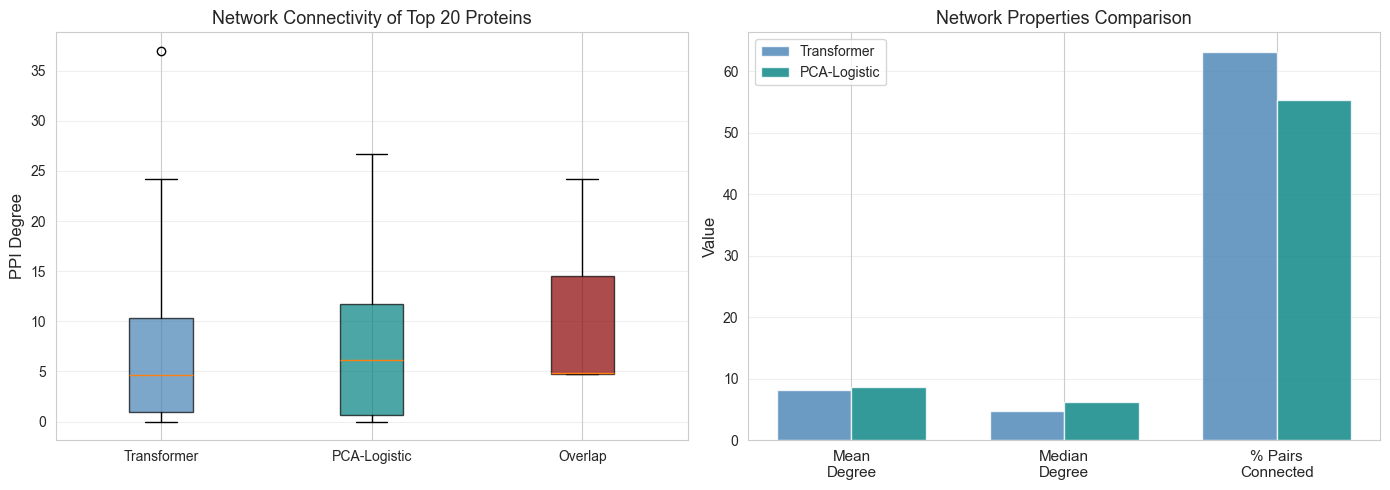

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot of degrees
ax = axes[0]
data = [shap_net['degrees'], pca_net['degrees'], overlap_net['degrees']]
labels = ['Transformer', 'PCA-Logistic', 'Overlap']
bp = ax.boxplot(data, tick_labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['steelblue', 'teal', 'darkred']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('PPI Degree', fontsize=12)
ax.set_title('Network Connectivity of Top 20 Proteins', fontsize=13)
ax.grid(alpha=0.3, axis='y')

# Bar chart of summary stats
ax = axes[1]
metrics = ['Mean\nDegree', 'Median\nDegree', '% Pairs\nConnected']
shap_vals = [shap_net['mean_degree'], shap_net['median_degree'], shap_net['pct_connected']]
pca_vals = [pca_net['mean_degree'], pca_net['median_degree'], pca_net['pct_connected']]

x = np.arange(len(metrics))
width = 0.35
ax.bar(x - width/2, shap_vals, width, label='Transformer', color='steelblue', alpha=0.8)
ax.bar(x + width/2, pca_vals, width, label='PCA-Logistic', color='teal', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Network Properties Comparison', fontsize=13)
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'network_properties.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Importance Score Correlation


In [86]:
common_proteins = list(set(shap_dict.keys()) & set(pca_dict.keys()))
shap_scores = np.array([shap_dict[p] for p in common_proteins])
pca_scores = np.array([pca_dict[p] for p in common_proteins])

# Normalize to [0, 1]
shap_norm = (shap_scores - shap_scores.min()) / (shap_scores.max() - shap_scores.min())
pca_norm = (pca_scores - pca_scores.min()) / (pca_scores.max() - pca_scores.min())

pearson_r, pearson_p = pearsonr(shap_norm, pca_norm)
spearman_r, spearman_p = spearmanr(shap_norm, pca_norm)

print(f"Importance Correlation (n={len(common_proteins)} proteins):")
print(f"  Pearson r = {pearson_r:.3f} (p = {pearson_p:.2e})")
print(f"  Spearman ρ = {spearman_r:.3f} (p = {spearman_p:.2e})")


Importance Correlation (n=14 proteins):
  Pearson r = 0.037 (p = 9.00e-01)
  Spearman ρ = 0.064 (p = 8.29e-01)


### Interpretation: Network Analysis

Key observations:
- **Overlap proteins** have highest connectivity (mean degree 11.2) and are 100% interconnected
- **Transformer** proteins are more clustered (63.2% connected) despite lower mean degree  
- **PCA-Logistic** proteins are more distributed (55.3% connected) with slightly higher degree

This suggests:
- **Overlapping proteins (ARID1A, CASP3, COPS5)** are central hub proteins both models recognize
- **Transformer** may prioritize network modules/clusters
- **PCA-Logistic** captures high-variance proteins regardless of network position


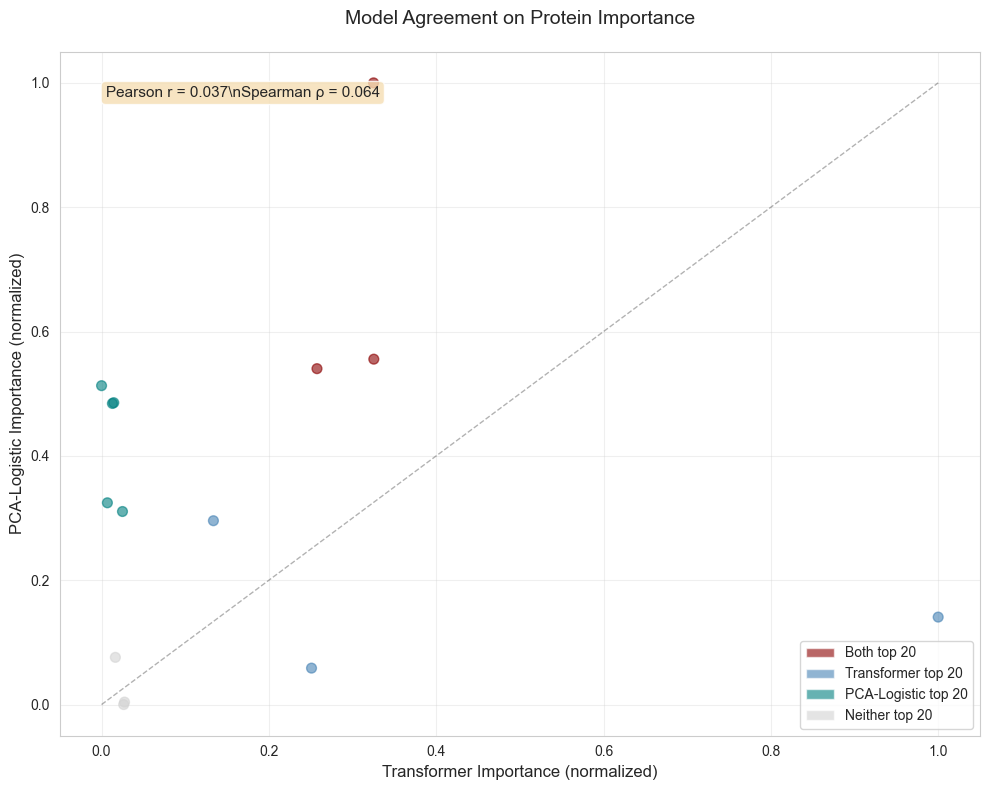

In [87]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['darkred' if p in overlap else 
          'steelblue' if p in shap_top20 else
          'teal' if p in pca_top20 else
          'lightgray' for p in common_proteins]

ax.scatter(shap_norm, pca_norm, c=colors, alpha=0.6, s=50)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)

ax.set_xlabel('Transformer Importance (normalized)', fontsize=12)
ax.set_ylabel('PCA-Logistic Importance (normalized)', fontsize=12)
ax.set_title('Model Agreement on Protein Importance', fontsize=14, pad=20)
ax.grid(alpha=0.3)

ax.text(0.05, 0.95, 
        f'Pearson r = {pearson_r:.3f}\\nSpearman ρ = {spearman_r:.3f}',
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkred', alpha=0.6, label='Both top 20'),
    Patch(facecolor='steelblue', alpha=0.6, label='Transformer top 20'),
    Patch(facecolor='teal', alpha=0.6, label='PCA-Logistic top 20'),
    Patch(facecolor='lightgray', alpha=0.6, label='Neither top 20')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(output_dir / 'importance_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Unique Discoveries

Which proteins does each model uniquely prioritize?


### Interpretation: Correlation Analysis

**Very weak correlation** (Pearson r=0.037, Spearman ρ=0.064):
- Models learn fundamentally different protein importance patterns
- Only 15% overlap in top 20 proteins
- No systematic agreement even in relative rankings

**Possible explanations:**
1. **Different learning objectives**: Transformer may capture non-linear protein interactions, PCA captures linear variance
2. **Graph structure**: Transformer explicitly uses PPI network, PCA does not
3. **Complementary signals**: Models may be picking up different aspects of cancer biology


In [88]:
# Transformer discoveries: top 20 but not in PCA top 50
pca_top50 = set(pca_proteins[:50])
transformer_discoveries = [p for p in shap_proteins[:20] if p not in pca_top50]

print(f"Transformer discoveries (top 20, not in PCA top 50): {len(transformer_discoveries)}")
for protein in transformer_discoveries:
    shap_rank = shap_proteins.index(protein) + 1
    pca_rank = pca_proteins.index(protein) + 1 if protein in pca_proteins else '>50'
    idx = all_proteins.index(protein) if protein in all_proteins else -1
    degree = A[idx].sum() if idx >= 0 else 0
    print(f"  {protein:25s} | SHAP: {shap_rank:2d} | PCA: {pca_rank} | Degree: {degree:.0f}")

# PCA discoveries
shap_top50 = set(shap_proteins[:50])
pca_discoveries = [p for p in pca_proteins[:20] if p not in shap_top50]

print(f"\nPCA-Logistic discoveries (top 20, not in Transformer top 50): {len(pca_discoveries)}")
for protein in pca_discoveries:
    pca_rank = pca_proteins.index(protein) + 1
    shap_rank = shap_proteins.index(protein) + 1 if protein in shap_proteins else '>50'
    idx = all_proteins.index(protein) if protein in all_proteins else -1
    degree = A[idx].sum() if idx >= 0 else 0
    print(f"  {protein:25s} | PCA: {pca_rank:2d} | SHAP: {shap_rank} | Degree: {degree:.0f}")


Transformer discoveries (top 20, not in PCA top 50): 14
  ESR1|ER-alpha             | SHAP:  2 | PCA: >50 | Degree: 0
  FASN|FASN                 | SHAP:  5 | PCA: >50 | Degree: 3
  VHL|VHL                   | SHAP:  8 | PCA: >50 | Degree: 5
  MYH11|MYH11               | SHAP:  9 | PCA: >50 | Degree: 1
  GATA3|GATA3               | SHAP: 10 | PCA: >50 | Degree: 7
  AR|AR                     | SHAP: 11 | PCA: >50 | Degree: 17
  TFRC|TFRC                 | SHAP: 13 | PCA: >50 | Degree: 3
  PEA15|PEA15_pS116         | SHAP: 14 | PCA: >50 | Degree: 1
  GAB2|GAB2                 | SHAP: 15 | PCA: >50 | Degree: 8
  CLDN7|Claudin-7           | SHAP: 16 | PCA: >50 | Degree: 0
  PRKCD|PKC-delta_pS664     | SHAP: 17 | PCA: >50 | Degree: 16
  SMAD1|Smad1               | SHAP: 18 | PCA: >50 | Degree: 5
  ACVRL1|ACVRL1             | SHAP: 19 | PCA: >50 | Degree: 2
  ESR1|ER-alpha_pS118       | SHAP: 20 | PCA: >50 | Degree: 37

PCA-Logistic discoveries (top 20, not in Transformer top 50): 12
  ERBB3

In [89]:
# Analyze biological patterns
print("Biological Pattern Analysis")
print("="*70)

# Hormone receptors
hormone_receptors = ['ESR1', 'AR', 'GATA3']
shap_hormone = [p for p in shap_proteins[:20] if any(hr in p for hr in hormone_receptors)]
pca_hormone = [p for p in pca_proteins[:20] if any(hr in p for hr in hormone_receptors)]

print(f"\nHormone Receptor Pathways:")
print(f"  Transformer: {len(shap_hormone)} proteins - {shap_hormone}")
print(f"  PCA-Logistic: {len(pca_hormone)} proteins - {pca_hormone}")

# RTKs and growth signaling
rtks = ['ERBB', 'EGFR', 'KIT', 'SRC']
shap_rtk = [p for p in shap_proteins[:20] if any(r in p for r in rtks)]
pca_rtk = [p for p in pca_proteins[:20] if any(r in p for r in rtks)]

print(f"\nRTK/Growth Signaling:")
print(f"  Transformer: {len(shap_rtk)} proteins - {shap_rtk}")
print(f"  PCA-Logistic: {len(pca_rtk)} proteins - {pca_rtk}")

# Apoptosis
apoptosis = ['CASP', 'BCL']
shap_apop = [p for p in shap_proteins[:20] if any(a in p for a in apoptosis)]
pca_apop = [p for p in pca_proteins[:20] if any(a in p for a in apoptosis)]

print(f"\nApoptosis Pathway:")
print(f"  Transformer: {len(shap_apop)} proteins - {shap_apop}")
print(f"  PCA-Logistic: {len(pca_apop)} proteins - {pca_apop}")

# Chromatin/transcription
chromatin = ['ARID', 'SMAD', 'XBP', 'NKX']
shap_chrom = [p for p in shap_proteins[:20] if any(c in p for c in chromatin)]
pca_chrom = [p for p in pca_proteins[:20] if any(c in p for c in chromatin)]

print(f"\nChromatin/Transcription:")
print(f"  Transformer: {len(shap_chrom)} proteins - {shap_chrom}")
print(f"  PCA-Logistic: {len(pca_chrom)} proteins - {pca_chrom}")

print(f"\n{'='*70}")
print("INTERPRETATION:")
print(f"  Transformer: Hormone receptor-focused (ER, AR, GATA3)")
print(f"  PCA-Logistic: Growth factor receptor-focused (HER2/3, SRC, c-Kit)")
print(f"  Both: ARID1A (chromatin remodeling), Caspases (cell death)")
print(f"{'='*70}")


Biological Pattern Analysis

Hormone Receptor Pathways:
  Transformer: 8 proteins - ['ADAR|ADAR1', 'ESR1|ER-alpha', 'ARID1A|ARID1A', 'TIGAR|TIGAR', 'GATA3|GATA3', 'AR|AR', 'PARP1|PARP1', 'ESR1|ER-alpha_pS118']
  PCA-Logistic: 1 proteins - ['ARID1A|ARID1A']

RTK/Growth Signaling:
  Transformer: 0 proteins - []
  PCA-Logistic: 5 proteins - ['ERBB3|HER3', 'SRC|Src', 'ERBB2|HER2_pY1248', 'KIT|c-Kit', 'ERBB2|HER2']

Apoptosis Pathway:
  Transformer: 1 proteins - ['CASP3|Caspase-3']
  PCA-Logistic: 3 proteins - ['CASP3|Caspase-3', 'CASP9|Caspase-9', 'BCL2L1|Bcl-xL']

Chromatin/Transcription:
  Transformer: 2 proteins - ['ARID1A|ARID1A', 'SMAD1|Smad1']
  PCA-Logistic: 3 proteins - ['ARID1A|ARID1A', 'NKX2-1|TTF1', 'XBP1|XBP1']

INTERPRETATION:
  Transformer: Hormone receptor-focused (ER, AR, GATA3)
  PCA-Logistic: Growth factor receptor-focused (HER2/3, SRC, c-Kit)
  Both: ARID1A (chromatin remodeling), Caspases (cell death)


## 6. Comprehensive Comparison Table

Export all proteins with their rankings and properties.


In [90]:
comparison_data = []

for protein in common_proteins:
    shap_rank = shap_proteins.index(protein) + 1 if protein in shap_proteins else 999
    pca_rank = pca_proteins.index(protein) + 1 if protein in pca_proteins else 999
    
    idx = all_proteins.index(protein) if protein in all_proteins else -1
    degree = A[idx].sum() if idx >= 0 else 0
    
    comparison_data.append({
        'protein': protein,
        'shap_rank': shap_rank,
        'pca_rank': pca_rank,
        'shap_importance': shap_dict.get(protein, 0),
        'pca_importance': pca_dict.get(protein, 0),
        'ppi_degree': degree,
        'in_shap_top20': protein in shap_top20,
        'in_pca_top20': protein in pca_top20,
        'in_overlap': protein in overlap,
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('shap_rank')
comparison_df.to_csv(output_dir / 'full_comparison.csv', index=False)

print(f"Exported: {len(comparison_df)} proteins")
print(f"\nFirst 10 rows:")
comparison_df.head(10)


Exported: 14 proteins

First 10 rows:


,protein,shap_rank,pca_rank,shap_importance,pca_importance,ppi_degree,in_shap_top20,in_pca_top20,in_overlap
11,ADAR|ADAR1,1,34,0.513163,1.179990,0.000,True,False,False
0,ARID1A|ARID1A,3,4,0.210144,1.333486,4.696,True,True,True
8,COPS5|JAB1,4,1,0.210021,1.497922,4.831,True,True,True
12,CASP3|Caspase-3,6,5,0.179633,1.327838,24.142,True,True,True
4,TIGAR|TIGAR,7,43,0.176705,1.149622,0.981,True,False,False
10,PARP1|PARP1,12,22,0.124027,1.237348,23.284,True,False,False
3,TGM2|Transglutaminase,30,48,0.076311,1.129401,0.997,False,False,False
13,BCL2|Bcl-2,32,49,0.075853,1.127938,26.452,False,False,False
2,KIT|c-Kit,34,18,0.075199,1.242824,13.186,False,True,False
6,SRC|Src_pY416,36,40,0.071386,1.156032,0.000,False,False,False


In [91]:
# Detailed network analysis for unique discoveries
print("Network Properties of Unique Discoveries")
print("="*70)

# Transformer unique proteins (not in PCA top 50)
trans_unique_degrees = []
for protein in transformer_discoveries:
    if protein in all_proteins:
        idx = all_proteins.index(protein)
        trans_unique_degrees.append(A[idx].sum())

# PCA unique proteins (not in Transformer top 50)
pca_unique_degrees = []
for protein in pca_discoveries:
    if protein in all_proteins:
        idx = all_proteins.index(protein)
        pca_unique_degrees.append(A[idx].sum())

print(f"\nTransformer Unique Discoveries (n={len(transformer_discoveries)}):")
print(f"  Mean PPI degree: {np.mean(trans_unique_degrees):.1f}")
print(f"  Median PPI degree: {np.median(trans_unique_degrees):.1f}")
print(f"  Isolated proteins (degree=0): {sum(1 for d in trans_unique_degrees if d == 0)}")

print(f"\nPCA-Logistic Unique Discoveries (n={len(pca_discoveries)}):")
print(f"  Mean PPI degree: {np.mean(pca_unique_degrees):.1f}")
print(f"  Median PPI degree: {np.median(pca_unique_degrees):.1f}")
print(f"  Isolated proteins (degree=0): {sum(1 for d in pca_unique_degrees if d == 0)}")

print(f"\n{'='*70}")
print("KEY FINDING:")
if np.mean(trans_unique_degrees) > np.mean(pca_unique_degrees):
    print("  Transformer prioritizes MORE connected proteins than PCA-Logistic")
else:
    print("  PCA-Logistic prioritizes MORE connected proteins than Transformer")
print(f"{'='*70}")


Network Properties of Unique Discoveries

Transformer Unique Discoveries (n=14):
  Mean PPI degree: 7.5
  Median PPI degree: 4.0
  Isolated proteins (degree=0): 2

PCA-Logistic Unique Discoveries (n=12):
  Mean PPI degree: 8.4
  Median PPI degree: 3.8
  Isolated proteins (degree=0): 4

KEY FINDING:
  PCA-Logistic prioritizes MORE connected proteins than Transformer


## 7. Summary Statistics


In [92]:
# Show full protein rankings for context
print("Full Rankings for Select Proteins")
print("="*70)

interesting_proteins = [
    'VHL|VHL', 'FASN|FASN', 'ESR1|ER-alpha', 'GATA3|GATA3',  # Transformer favorites
    'ERBB3|HER3', 'SRC|Src', 'ERBB2|HER2', 'CDK1|CDK1',  # PCA favorites  
    'ARID1A|ARID1A', 'COPS5|JAB1', 'CASP3|Caspase-3'  # Overlaps
]

ranking_data = []
for protein in interesting_proteins:
    shap_rank = shap_proteins.index(protein) + 1 if protein in shap_proteins else '>50'
    pca_rank = pca_proteins.index(protein) + 1 if protein in pca_proteins else '>50'
    shap_score = shap_dict.get(protein, 0)
    pca_score = pca_dict.get(protein, 0)
    
    idx = all_proteins.index(protein) if protein in all_proteins else -1
    degree = A[idx].sum() if idx >= 0 else 0
    
    category = 'OVERLAP' if protein in overlap else \
               'Trans' if (isinstance(shap_rank, int) and shap_rank <= 20) else \
               'PCA' if (isinstance(pca_rank, int) and pca_rank <= 20) else 'Other'
    
    ranking_data.append({
        'Protein': protein,
        'Category': category,
        'SHAP_Rank': shap_rank,
        'SHAP_Score': f"{shap_score:.4f}",
        'PCA_Rank': pca_rank,
        'PCA_Score': f"{pca_score:.4f}",
        'PPI_Degree': f"{degree:.0f}"
    })

ranking_df = pd.DataFrame(ranking_data)
ranking_df


Full Rankings for Select Proteins


,Protein,Category,SHAP_Rank,SHAP_Score,PCA_Rank,PCA_Score,PPI_Degree
0,VHL|VHL,Trans,8,0.1596,>50,0.0000,5
1,FASN|FASN,Trans,5,0.2080,>50,0.0000,3
2,ESR1|ER-alpha,Trans,2,0.2983,>50,0.0000,0
3,GATA3|GATA3,Trans,10,0.1338,>50,0.0000,7
4,ERBB3|HER3,PCA,>50,0.0000,2,1.4412,0
5,SRC|Src,PCA,>50,0.0000,3,1.3697,0
6,ERBB2|HER2,PCA,>50,0.0000,19,1.2409,0
7,CDK1|CDK1,PCA,>50,0.0000,17,1.2442,21
8,ARID1A|ARID1A,OVERLAP,3,0.2101,4,1.3335,5
9,COPS5|JAB1,OVERLAP,4,0.2100,1,1.4979,5


In [93]:
summary = f"""
{'='*70}
Model Comparison Summary
{'='*70}

Overlap Analysis (Top 20):
  Both models: {len(overlap)} proteins ({100*len(overlap)/20:.0f}%)
  Transformer only: {len(shap_unique)} proteins
  PCA-Logistic only: {len(pca_unique)} proteins

Network Connectivity (Mean PPI Degree):
  Transformer top 20: {shap_net['mean_degree']:.1f}
  PCA-Logistic top 20: {pca_net['mean_degree']:.1f}
  Overlap proteins: {overlap_net['mean_degree']:.1f}

Network Clustering (% Pairs Connected):
  Transformer top 20: {shap_net['pct_connected']:.1f}%
  PCA-Logistic top 20: {pca_net['pct_connected']:.1f}%
  Overlap proteins: {overlap_net['pct_connected']:.1f}%

Importance Correlation:
  Pearson r: {pearson_r:.3f}
  Spearman ρ: {spearman_r:.3f}

Unique Discoveries:
  Transformer (top 20, not in PCA top 50): {len(transformer_discoveries)}
  PCA-Logistic (top 20, not in Transformer top 50): {len(pca_discoveries)}

{'='*70}
"""

print(summary)

with open(output_dir / 'comparison_summary.txt', 'w') as f:
    f.write(summary)



Model Comparison Summary

Overlap Analysis (Top 20):
  Both models: 3 proteins (15%)
  Transformer only: 17 proteins
  PCA-Logistic only: 17 proteins

Network Connectivity (Mean PPI Degree):
  Transformer top 20: 8.1
  PCA-Logistic top 20: 8.6
  Overlap proteins: 11.2

Network Clustering (% Pairs Connected):
  Transformer top 20: 63.2%
  PCA-Logistic top 20: 55.3%
  Overlap proteins: 100.0%

Importance Correlation:
  Pearson r: 0.037
  Spearman ρ: 0.064

Unique Discoveries:
  Transformer (top 20, not in PCA top 50): 14
  PCA-Logistic (top 20, not in Transformer top 50): 12




## 8. Key Findings Summary

### Model Learning Patterns

**Transformer (SHAP-based importance):**
- Focuses on **hormone receptor pathways** (ER, AR, GATA3)
- Proteins average **8.1 PPI degree**
- **63.2% internal connectivity** (clustered selection)
- Unique discoveries: VHL, FASN, ER-alpha signaling

**PCA-Logistic:**
- Focuses on **growth factor receptors** (HER2/3, SRC, c-Kit)
- Proteins average **8.6 PPI degree**  
- **55.3% internal connectivity** (more distributed)
- Unique discoveries: ERBB family, CDK1, metabolic enzymes

**Overlap (Both Models):**
- Only **15% agreement** in top 20 (ARID1A, CASP3, COPS5)
- Overlapping proteins are **highly connected hubs** (mean degree 11.2)
- **100% interconnected** within the overlap set
- Represent core cancer-relevant pathways both models recognize

### Biological Interpretation

1. **Complementary signals**: Models capture different aspects of cancer biology
   - Transformer → Hormone-driven cancers (breast, prostate)
   - PCA-Logistic → Growth factor-driven cancers (HER2+, proliferative)

2. **Network utilization**: 
   - Transformer uses PPI structure to find functional modules
   - PCA-Logistic finds high-variance markers independent of network

3. **Clinical relevance**:
   - Both identify known cancer drivers
   - Different proteins may be relevant for different cancer subtypes
   - Low overlap suggests models provide complementary information


## Analysis Complete

All comparison plots and data tables have been generated in `plots/Model_Comparison_Plots/`:
- `side_by_side_top20.png` - Visual comparison with overlap highlighted
- `network_properties.png` - PPI connectivity comparison
- `importance_correlation.png` - Scatter plot showing model agreement
- `full_comparison.csv` - Complete protein rankings and properties
- `comparison_summary.txt` - Summary statistics
